**WORK IN PROGRESS**

# Purpose

To develop a dataset of simulated patients attending ED with uncomplicated sepsis. 

This dataset arose from a [recent article][1] that described how an active sepsis alert system reduced inpatient mortality and morbidity on a large scale. This investigation was driven by the lack of large scale studies investigating the effectiveness of such a system. As ED is the first port of call for most patients, it may be useful to apply similar systems in such a setting. The following dataset simulates an adult ED population of a typical Irish hospital, and the number of patients with uncomplicated sepsis in that population.

For the purpose of this dataset, the outcome of interest is recognition of uncomplicated sepsis in an average ED population. In order for sepsis to be present, an infective source needs to be present. It will be assumed that if any of the patients within the dataset fulfill the criteria for sepsis, that they have a likely infective source. Secondly, the dataset will only make use of clinical parameters that can be measured at presentation; that is, laboratory parameters will not be included in the dataset. The 'general variables' presented in Appendix 7 of the [National Clinical Effectiveness Committee's Sepsis Managament National Clinical Guideline No. 6][2] will be the only variables of interest included in the dataset. These are as follows, and align with the variables used to measure the [prevalence of uncomplicated sepsis in Irish ED's][3]: 
1. Temperature <36 or >38.3 degrees celsius
2. Heart rate >90 beats per minute
3. Respiratoty rate >20 breaths per minute
4. Altered mental state, recorded as 'Yes' or 'No'
5. Blood glucose level of >7.7 mmol/L in non-diabetic (for the sake of this dataset, all patients are non-diabetic)

[1]: https://academic.oup.com/jamia/advance-article/doi/10.1093/jamia/ocz186/5607431
[2]: https://assets.gov.ie/11620/4678fb449336482fb291a140ef67e570.pdf
[3]: http://imj.ie/3171-2/

## Proportion of adult (>18 yrs) patients attending Irish emergency departments
According to the Central Statistics Office (CSO), 10% of the adult Irish population who took part in the [Quarterly National Household Survey Q3 2010][1] attended an accident and emergency (A&E) department in the 12 months prior to the survey. Based on the [2016 census][2], the population of Ireland >18 years of age was estimated at 3,424,795, which equates to roughly 9,383 A&E visits across the country every day. However, a report by the [HSE in 2006][3] placed this figure closer to 3,300. For the interest of this project, we will work with a daily A&E attendance number of 3,500. 

Presentations to A&E are not evenly distributed across the age categories, with a bimodal presentation with peaks at 18-24 and 70+. Thus, the first parameter for our dataset, namely age, [can be selected from two normal distributions][4] with means at 18 and 70 respectively, standard deviations of 15. This generates a bimodal distribution as shown in the following plot:

[1]: https://www.cso.ie/en/media/csoie/releasespublications/documents/labourmarket/2010/healthstatusq32010.pdf
[2]: https://statbank.cso.ie/px/pxeirestat/Statire/SelectVarVal/saveselections.asp
[3]: https://www.hse.ie/eng/services/publications/hospitals/hse-emergency-departments--patient-profiles,-experiences-and-perceptions.pdf
[4]: https://medium.com/@michellemho/faking-data-87c063cf38a7

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(array([  4.,  27.,  89., 197., 271., 222., 133.,  46.,  10.,   1.]),
 array([ 22.78290508,  32.92523131,  43.06755753,  53.20988376,
         63.35220998,  73.4945362 ,  83.63686243,  93.77918865,
        103.92151488, 114.0638411 , 124.20616733]),
 <a list of 10 Patch objects>)

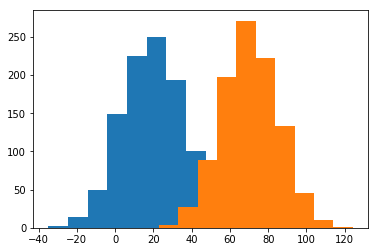

In [2]:
# Generate two normal distributions of 1,000 values, young and old, with mean of 18 and 70 respectively, 
# and standard deviation of 15
y = np.random.normal(18, 15, 1000)
o = np.random.normal(70, 15, 1000)

# Plot histograms the two distributions on the same plot
plt.hist(y)
plt.hist(o)

Thus, two normal distributions give us a bimodal distribution that represents the distribution as it occurs in reality.

However, for the purpose of this exercise, we want to limit our sample to those over 18 years, and under 75 years of age. We also want to create a sample size of 3,500 'patients'. As the data shows that there is roughly an equal proportion of those in the 18-24 age bracket (13%) and the 70+ age bracket (11%), we will sample an equal proportion from each distribution.

In [3]:
# Create counter and population size
count = 0
pop = 3500

# Create list of ages (this will be converted to a dataframe for analysis in due course)
ages = []

# Generate a random list of 3,500 ages from a bimodal distribution
# Run through the random samples as they are generated, and only add ages > 18 and < 75 to the list
while count < pop:
    yng = int(np.random.normal(18, 15)) # Young normal distribution centred around a mean of 15, SD of 15
    # print(yng)
    old = int(np.random.normal(70, 15)) # Old normal distribution centred around a mean of 70, SD of 15
    # print(old)
    if yng < 18:
        continue
    if old > 75:
        continue
    else:
        ages.append(yng)
        ages.append(old)
        count += 2 # Increment count by 2 each time for yng and old age addition

(array([569., 484., 338., 203., 233., 221., 259., 371., 408., 414.]),
 array([18. , 23.7, 29.4, 35.1, 40.8, 46.5, 52.2, 57.9, 63.6, 69.3, 75. ]),
 <a list of 10 Patch objects>)

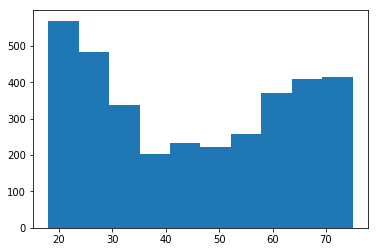

In [4]:
# Plot list to confirm bimodal distribution
plt.hist(ages)

#### Create dataset of 'normal' patients
First, we will create a dataset of patients with ['normal' vital signs][1]. We will select these vital signs from a normal distribution within a set range. We will then select a portion of this sample to be sepsis patients and adjust their parameters accordingly. 

Normal value ranges:
- temp: 36.5 to 37.3 degrees celsius
- heart rate: 60 to 100 beats per minute
- respiratory rate: 12 to 18 breaths per minute
- altered mental state: No
- [blood glucose level][2]: (fasting) 4.0 to 5.9mmol/L, up to 7.7mmol/L after meals 

For the purposes of this equation, the mean for each value (apart from mental state) will be the median of the ranges shown. The standard deviation (SD) will be 1/3 the value between the median and the lower/upper limit of the range. This will ensure that 99% of values chosen are within the ranges shown. As a normal distribution is asymptotic, additional conditionals will be employed to ensure all values fall between the ranges as shown.

[1]: https://medlineplus.gov/ency/article/002341.htm
[2]: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html

In [5]:
'''Create values function to select values from normal range:
    Takes 3 arguments type integer or float:
                        a = lower range limit
                        b = upper range limit
                        size = population size
    Returns a list of values from a normal distribution between a and b of size 'size' '''


def values(a, b, size): # a and b are range limits; size is population size
    # calculate mean
    mn = abs(round((b+a)/2, 2))
    
    # calculate sd
    sd = abs(round((a-mn)/3, 2))
    
    # set counter
    count = 0
    
    # create empty list
    ls = []
    
    # determine values
    while count < size:
        x = (np.random.normal(mn, sd))
        if x < a or x > b:
            continue
        else:
            ls.append(x)
            count += 1
        
    # return list
    return ls

In [6]:
# Create lists of normal vital signs
temp = values(36.5, 37.3, pop)
hr = values(60, 100, pop)
rr = values(12, 18, pop)
gluc = values(4.0, 7.7, pop)

In [7]:
# Create dataframe of 'normal' patient values - https://stackoverflow.com/a/30522778
df = pd.DataFrame({'age': ages, 'temp': temp, 'pulse': hr, 'resp_rate': rr, 'sugar': gluc})

In [8]:
# Round values appropriately - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.round.html
df = df.round({'temp': 1, 'pulse': 0, 'resp_rate': 0, 'sugar': 1})

In [9]:
# Convert pulse and resp rate float columns to integers - https://stackoverflow.com/a/21291622
df.pulse = df.pulse.astype(int)
df.resp_rate = df.resp_rate.astype(int)

In [10]:
# Add in the mental status column with all values at 'No' - https://www.interviewqs.com/ddi_code_snippets/add_new_col_df_default_value
df['alt_ment'] = 'no'

# Add in sepsis column with all values at 'no'
df['sepsis'] = 'no'

In [11]:
# Confirm that values entered of correct type
print(df.dtypes)

age            int64
temp         float64
pulse          int64
resp_rate      int64
sugar        float64
alt_ment      object
sepsis        object
dtype: object


In [12]:
# Confirm dataframe stored correctly
df.head()

,age,temp,pulse,resp_rate,sugar,alt_ment,sepsis
0,19,36.8,83,14,6.0,no,no
1,62,36.9,96,14,5.7,no,no
2,19,36.8,66,14,6.2,no,no
3,43,36.9,75,15,6.1,no,no
4,29,37.3,79,15,6.5,no,no


##### Create sepsis patients
According to a [study][1] conducted in one of the busiest EDs in Ireland, roughly 4.24% of ED presentations are suffering from sepsis. This proportion is not evenly distributed, with older patients more likely to have sepsis (median 45 without sepsis versus a median of 65 for those with sepsis). In order to accurately reflect this, we will randomly select 4% of the sample between the ages of 50 and 75 to have sepsis. We will then select 0.5% from the remaining sample (<50) to have sepsis to represent the possibility of sepsis at all ages.

Not making decision on gender as per article.

[1]: https://www.lenus.ie/bitstream/handle/10147/620877/art3.html?sequence=1

All samples drawn from uniform distribution. Why not normal? As mean unknown, don't know if these samples are skewed. And what is the SD? However, is possible to calculate this from median ans IQR if assumed normal distribution - mean = median, SD = IQR/1.35 (https://www.researchgate.net/post/Is_there_any_way_to_get_mean_and_SD_from_median_and_IQR_interquartile_range)

Median hearbeat from study - 104, IQR 89-113. Thus, draw from range 91 to 130 (IQR between median and IQR is 15. Assuming that additional 15 on top end is complete range of study, thus 130).

Temp - median of 36.7, IQR of 36 to 38. Thus, applying above logic again, upper end of range is 39.3, lower end of range is 36 - 0.7 = 35.3. Need to select randomly from lower (<36) or upper range (>38.3).

Median resp rate was 18, IQR 16-20. Thus, applying same principle as above, range is 14-22. Only rr > 20 is indicative. 

Sugar median was 7.6, IQR 6-9 mmol/L. thus, applying same above principle, range is 4.4 - 10.4. Thus, sepsis is range 7.8 to 10.4

In [13]:
# Create proportion of sample
older = int(pop*0.04)
rest = int(pop*0.005)

In [74]:
def sepsis(a, b): # a is the df row; b is the number of variables to change
    vitals = np.array(['temp', 'pulse', 'resp_rate', 'sugar', 'alt_ment']) # https://docs.scipy.org/doc/numpy-1.13.0/user/basics.creation.html
    print(vitals)
    for i in range(b):
    # Randomly select variables to change
        vc = np.random.choice(vitals)
        vitals = vitals[vitals!=vc] # https://thispointer.com/delete-elements-from-a-numpy-array-by-value-or-conditions-in-python/
        print(vc)
        print(vitals)
        if vc == 'pulse':
            a.at[:, 'pulse'] = np.random.randint(91, 131)
            print(a)
        if vc == 'temp':
            # decide on random upper or lower limit using binomial distribution
            dec = np.random.binomial(1, 0.5)
            if dec == 1:
                a.at[:, 'temp'] = np.random.choice(np.arange(38.3, 39.4))
            else:
                a.at[:, 'temp'] = np.random.choice(np.arange(35.3, 36.1))
            print(a)
        if vc == 'resp_rate':
            a.at[:, 'resp_rate'] = np.random.randint(21, 23)
            print(a)
        if vc == 'sugar':
            a.at[:, 'sugar'] = np.random.choice(np.arange(7.8, 10.5))
            print(a)
        if vc == 'alt_ment':
            a.at[:, 'alt_ment'] = 'yes'
            print(a)
    a.at[:, 'sepsis'] = 'yes'  
    print(a)
            
            

In [80]:
x = df[df['age'] >= 50].sample()
print(x)
print()
sepsis(x, 2)

     age  temp  pulse  resp_rate  sugar alt_ment sepsis
947   71  36.7     78         15    5.6       no     no

['temp' 'pulse' 'resp_rate' 'sugar' 'alt_ment']
alt_ment
['temp' 'pulse' 'resp_rate' 'sugar']
     age  temp  pulse  resp_rate  sugar alt_ment sepsis
947   71  36.7     78         15    5.6      yes     no
temp
['pulse' 'resp_rate' 'sugar']
     age  temp  pulse  resp_rate  sugar alt_ment sepsis
947   71  35.3     78         15    5.6      yes     no
     age  temp  pulse  resp_rate  sugar alt_ment sepsis
947   71  35.3     78         15    5.6      yes    yes


In [15]:
vitals = np.array(['temp', 'pulse', 'resp_rate', 'sugar', 'alt_ment'])
vc = np.random.choice(vitals, replace=False)
if vc == 'temp':
    print(vc)
    print(vitals)

Selecting number of vitals to change - not evenly distributed. Proportion decreases with following p:
2 - 55% of patients
3 - 36%
4 - 7%
5 - 2%
Need to reflect this in numbers

In [23]:
# Create loop to change proportion of sample

# Reset counter
count = 0

# Run through older proportion of sample 
while count < 1:
    # Choose observation randomly, but weighted to select over 50
    x = df[df['age'] >= 50].sample() # https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/
    # print(x)
    if (x['sepsis'] == 'yes').bool(): # https://stackoverflow.com/a/36922103
        continue
    # Randomly determine number of vital signs to change - 2, 3, 4, or 5 - with reducing probability - https://stackoverflow.com/a/4266645
    num = np.random.choice(np.arange(2, 6), p=[0.55, 0.36, 0.07, 0.02])
    print(num)
    # Adjust the corresponding number of vital signs using the sepsis function
    sepsis(x, num)
    count += 1
    

2


In [ ]:
np.random.randint(2, 6)

In [ ]:
x = df[df['age'] >= 50].sample()
if (x['sepsis'] == 'no').bool():
    print('no')

In [ ]:
# Create sepsis function
def sepsis(a): # a is the df frame
    # Choose observation randomly, but weighted to select over 50
    x = df[df['age'] >= 50].sample() # https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/
    print(x)

In [ ]:
# Select random sample weighted for those over 50
df[df['age'] >= 50].sample() # https://www.pybloggers.com/2018/11/how-to-use-pandas-sample-to-select-rows-and-columns/

In [ ]:
df[df['age'] < 50].sample(rest)

In [ ]:
df